In [1]:
import os
import re
import sys
import sklearn as skl
import math

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import sklearn.cluster

import glob

from data_grid import DataGrid

from sklearn.decomposition import PCA

from sklearn.decomposition import NMF

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.metrics import adjusted_mutual_info_score as ami_score

from sklearn.metrics import fowlkes_mallows_score as fm_score

from sklearn.metrics import adjusted_rand_score as ar_score

from data_grid_TiNiSn import DataGrid, DataGrid_TiNiSn_500C, DataGrid_TiNiSn_600C

from Agglo_cluster import Agglo_cluster

from peak_removal import peak_rem

import dataproc.operations

from dataproc.operations.hitp import bayesian_block_finder
from dataproc.operations.peakShapes import voigtFn
from NMF import nmf_func
from scipy.signal import find_peaks
from scipy.stats import pearsonr
from NMF_Cluster import nmf_cluster

In [2]:
dataGrid = DataGrid_TiNiSn_500C()
y_data=dataGrid.get_data_array()
x_data=dataGrid.data[1][:,0]

Loading Data from: C:/Users/oluwa/Downloads/TiNiSn_500C-20200714T190740Z-001/TiNiSn_500C/
Data Loaded Succesfully
(177, 800)


In [3]:
X = dataGrid.get_data_array()

(177, 800)


In [4]:
truth_labels=list([4,4,4,4,4])+list([4,4,4,4,4,4,4,3,3])+list([4,4,4,4,4,4,4,3,3,3,3])+list([4,4,4,11,4,4,4,4,3,3,3,2,2])+list([4,4,4,11,11,4,4,4,3,3,2,2,1])+list([5,5,4,11,11,11,4,4,5,5,2,2,1,1,1])+list([6,5,5,11,11,11,4,5,5,2,2,1,1,1,1])+list([7,6,5,5,11,11,5,5,2,2,1,1,1,1,1])+list([7,7,6,5,5,5,5,10,10,2,1,1,1,1,1])+list([7,7,6,6,10,10,10,10,10,9,1,1,1,1,1])+list([8,8,6,6,6,6,9,9,9,1,1,1,1])+list([8,8,8,6,9,9,9,9,9,1,1,1,1])+list([8,8,6,9,9,9,9,1,1,1,1])+list([8,6,9,9,9,9,1,1,1])+list([9,9,9,1,1])

In [5]:
#This part of the code is a savior
new_truth_labels=[None]*177
for ii in range(0,177):
    x,y=dataGrid.coord(ii+1)
    new_grid=dataGrid.grid_num(16-x,y)
    new_truth_labels[new_grid-1]=truth_labels[ii]

# Comparing similarities of clusters in Ground truth

In [6]:
def similarity2(a,b, metric='cosine'):    
        #a = np.log(a+1)
        #b = np.log(b+1)
        #a = np.square(a)
        #b = np.square(b)
        
        if metric == 'cosine':
            dot_product = np.dot(a, b)
            norm_a = np.linalg.norm(a)
            norm_b = np.linalg.norm(b)
            return 1 - (dot_product / (norm_a * norm_b))
            #return np.abs((dot_product / (norm_a * norm_b)))
        if metric == 'Euclidean':
            return np.sqrt(np.sum(np.square(b-a)))
        if metric == 'sEuclidean':
            return np.sum(np.square(b-a))
        if metric == 'Manhattan':
            return np.sum(np.abs(b-a))
        if metric == 'None':
            return np.mean(np.abs(b-a))
        

In [7]:
#Get the spectra grid numbers in each cluster
Big_clustlab=[]
for i in range(1,max(new_truth_labels)+1):
    clustlab=[]
    for j,v in enumerate(new_truth_labels):
        if v==i:
            clustlab.append(j+1)
    Big_clustlab.append(clustlab)

In [33]:
#Get the dissimilarity between each member of a cluster
size = max(new_truth_labels)

Big_D=[]

for clust in range(size):
    size2 = len(Big_clustlab[clust])
    small_d = np.zeros(shape = (size2,size2))
             
    for x in range(size2):
        for y in range(size2):
            a = X[Big_clustlab[clust][x]-1]
            b = X[Big_clustlab[clust][y]-1]
            small_d[x,y] = similarity2(a,b,'cosine')
            #print(small_d[x][y])
    
    Big_D.append(small_d)



np.shape(Big_D[0])

(40, 40)

In [34]:
#Get dissimilarity between a spectrum and a member/spectrum of other clusters
size = max(new_truth_labels)
Bigger_D = []

for clust in range(size):
    #size3 = len(Big_clustlab[clust])
    big_dd =[]
    
    for i in range(len(Big_clustlab[clust])):
        b = X[Big_clustlab[clust][i]-1]
        
        small_dd = [] #this shd have a length of 11
        
        for x in range(size):
            smaller_dd = [0]*len(Big_clustlab[x])
            for y in range(len(Big_clustlab[x])):
                a = X[Big_clustlab[x][y]-1]
                smaller_dd[y] = similarity2(a,b,'cosine')
            
            small_dd.append(smaller_dd)
        
        big_dd.append(small_dd)
        
    Bigger_D.append(big_dd)
    
np.shape(Bigger_D[0][0][0])

(40,)

In [10]:
np.shape(Bigger_D[1][10][0])

(40,)

In [11]:
np.transpose([np.mean(Bigger_D[0][i][0]) for i in range(40)])

array([12575.75617128, 12214.71003464,  9563.16022523, 10735.53774168,
       10097.68206655,  9713.73093637,  8576.05040347, 10428.74131831,
        8460.19875857,  8171.1365364 ,  8765.16129721,  9021.9114001 ,
       11267.09490741,  8289.26398505,  7005.95495971,  7449.28132574,
        9258.22357652, 10217.5977018 ,  8848.70500465,  6726.70040007,
        7521.22956003, 10034.82922671,  8622.54450847,  7492.30826369,
        7167.93443913,  7723.46459299,  8869.02970232,  8512.34457609,
        7017.0089572 ,  6984.17664269,  7759.18545375,  7459.72381353,
        6933.56751075,  7945.60458235,  7711.78588397,  7356.86491476,
        8427.76031401,  8784.66739103,  9801.87707767,  7742.46291563])

In [12]:
np.mean(Big_D[8],axis=1)

array([11556.65245623,  9994.8635389 ,  9270.3337879 ,  9549.0462989 ,
       11075.04903908,  7722.15906602,  7479.82447803,  8222.66597934,
        9256.69948849,  8454.87553589,  7175.7994012 ,  7256.16538685,
        8918.53804198,  9679.45953718,  6891.17555046,  7976.14434035,
        9324.08718921,  7547.1424558 ,  7691.84067803,  9876.87466033])

In [35]:
#Get average dissimilarity between a cluster's spectrum and other members of a specific clusters and 
#also find the average of that

mean_Bigger_D=[]

for clust in range(len(Bigger_D)):
    mD =[]
    for clust2 in range(len(Bigger_D)):
        clust_mean = np.mean([np.mean(Bigger_D[clust][i][clust2]) for i in range(len(Bigger_D[clust]))])
        if clust == clust2: clust_mean = 0
        
        mD.append(clust_mean)
    
    mean_Bigger_D.append(mD)
    
mean_Bigger_D[1]

[0.1470427503562073,
 0,
 0.22490506754283004,
 0.36095614047397634,
 0.18766652366593625,
 0.20945827100662812,
 0.435857750083985,
 0.37427952283946825,
 0.20465391311846906,
 0.11016292561673856,
 0.3309395739004425]

In [14]:
np.mean(np.mean(Big_D[0],axis=1))

8681.374226937833

#### list array behaves weird here, try it

In [15]:
small_d = [[None]*size2]*size2
small_d[3][3]=6
small_d[2][3]=3
small_d[3][3]

3

In [36]:
#Get average of the spectra in each cluster
Big_clustave = [] 

for i in range(0,max(new_truth_labels)):
    specta =[]
    for j in range(0,len(Big_clustlab[i])):
        b = Big_clustlab[i][j]
        specta.append(X[b-1])
    clustave = np.mean(specta,axis=0)
        
    Big_clustave.append(clustave)

    
#np.shape(specta)

In [37]:
#Get the dissimilarity between the ave spectrum of a cluster and members of that cluster
size = len(Big_clustave)

D = []
for clust in range(size):
    dd = []
    for i in range(len(Big_clustlab[clust])):
        d1 = Big_clustlab[clust][i]
        b = Big_clustave[clust]
        a = X[d1-1]
        dd.append(similarity2(a,b,'cosine'))
    D.append(dd)
    
    
#Get dissimilarity between each ave spectrum and the other
D_ave=np.ones(shape=(size,size))

for x in range(size):
    for y in range(size):
        a = Big_clustave[x]
        b = Big_clustave[y]
        D_ave[x,y] = similarity2(a,b,'cosine')
        
        
np.shape(Big_clustave)

(11, 800)

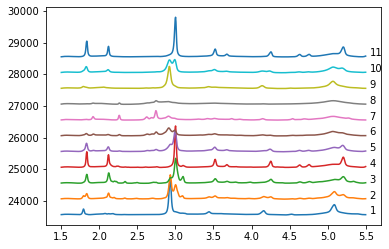

In [30]:
fig,ax = plt.subplots()
for ii in range(len(Big_clustave)):
    ax.plot(x_data,Big_clustave[ii]+pp)

    ax.annotate(ii+1,(5.55,pp+20))
    pp +=500

In [20]:
np.shape(Big_D[10])

(11, 11)

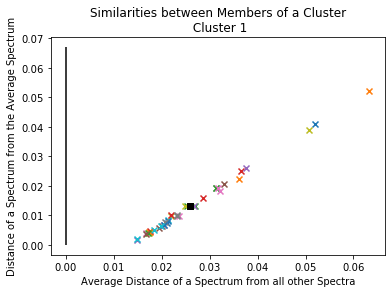

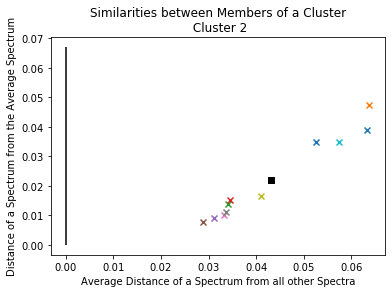

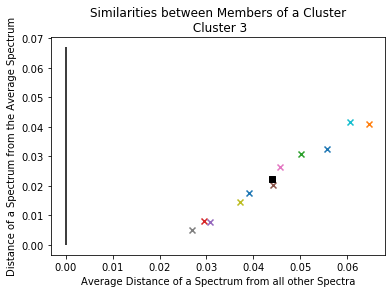

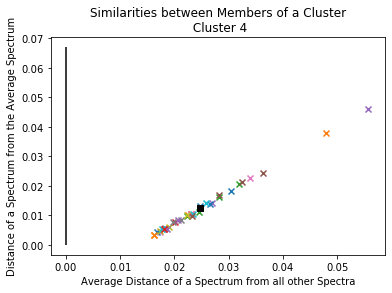

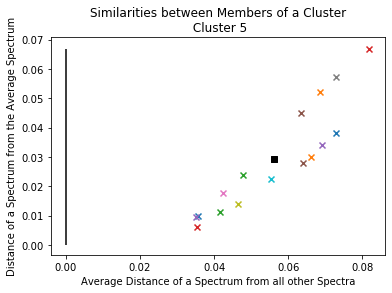

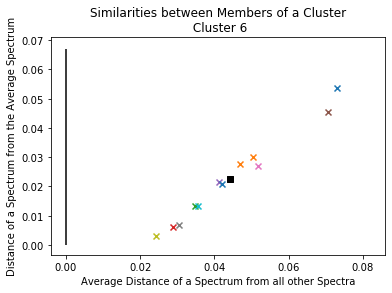

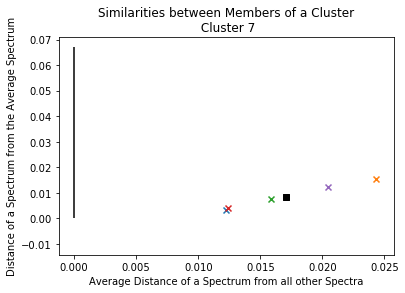

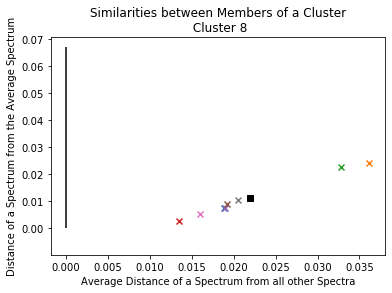

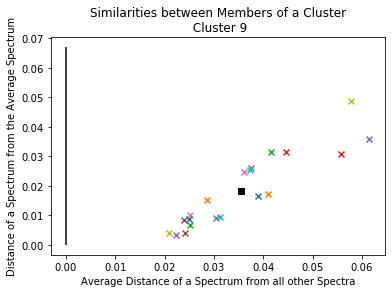

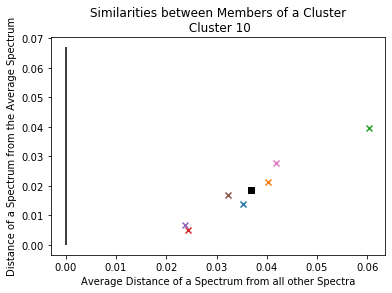

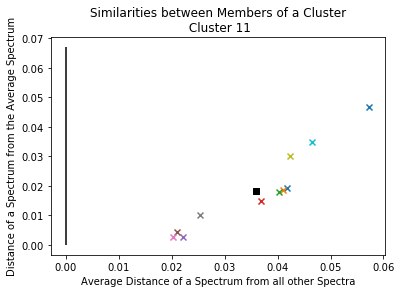

In [38]:
#Plot the similarity map for all clusters (ave)
max_sim = max([max(D[i]) for i in range(len(D))])

#fig,ax = plt.subplots(figsize=(15,6))
for clust in range(len(Big_D)):
    fig,ax = plt.subplots()
    for j in range(len(Big_D[clust])): 
        #ax.scatter([clust+1+np.mean(Big_D[clust][j])],D[clust][j],marker='x')
        ax.scatter([0+np.mean(Big_D[clust][j])],D[clust][j],marker='x')
        
#     ax.scatter([clust+1+np.mean(Big_D[clust])],np.mean(D[clust]),color='k',marker ='s')
#     plt.vlines(clust+1,0,max_sim,color='k')
    ax.scatter([0+np.mean(Big_D[clust])],np.mean(D[clust]),color='k',marker ='s')
    plt.vlines(0,0,max_sim,color='k')
    ax.set_title('Similarities between Members of a Cluster'+'\n Cluster '+str(clust+1))
    plt.ylabel("Distance of a Spectrum from the Average Spectrum")
    plt.xlabel("Average Distance of a Spectrum from all other Spectra")
    


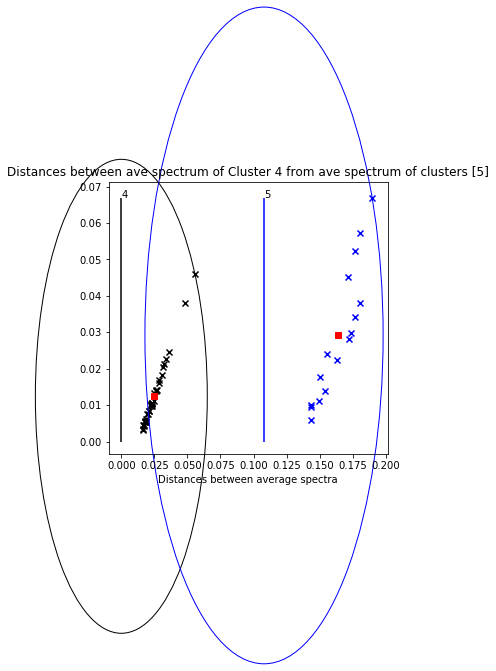

In [40]:
#Plot the similarity map for clusters 4 & 11 (ave)
max_sim = max([max(D[i]) for i in range(len(D))])

fig,ax = plt.subplots(figsize=(5,5))
pp=0
v=[4,5]
color = ['k','b','c','m','y','k','b','c','m','y','b']
color_idx=0
for i in range(len(v)):
    clust = v[i]-1
    
    for j in range(len(Big_D[clust])): 
        ax.scatter(pp+np.mean(Big_D[clust][j]),D[clust][j],marker='x',color=color[color_idx])
        #ax.scatter([pp]*len(D[v[i]]),D[v[i]],marker='x')
    plt.xlabel('Distances between average spectra')
    plt.ylabel('')
    ax.set_title('Distances between ave spectrum of Cluster '+str(v[0])+ ' from ave spectrum of clusters ' +str(v[1:]))
    ax.scatter(pp+np.mean(Big_D[clust]),np.mean(D[clust]),color = 'r',marker ='s')
    plt.vlines(pp,0,max_sim,color=color[color_idx])
    #plt.vlines(pp,-0.1,0.1,color=color[color_idx])
    ax.annotate(clust+1,(pp,max_sim))
   
    
    #ax.set_xlim((-0.01,0.1))
    #ax.set_ylim((0,0.1))
    
    circle_idx = np.argmax(np.mean(Big_D[clust],axis=1))
    x1=max(np.mean(Big_D[clust],axis=1))
    y1=D[clust][circle_idx]-np.mean(D[clust])
    rad = np.linalg.norm([x1,y1])
    circle1 = plt.Circle((pp,np.mean(D[clust])), rad, color=color[color_idx], fill=False,clip_on=False)
    #ax.gca()
    ax.add_artist(circle1)
    
    if i==len(v)-1:
        continue
    pp = D_ave[v[0]-1][v[i+1]-1]
    #pp = mean_Bigger_D[v[0]-1][v[i+1]-1]
    color_idx+=1
    #print(max(D[clust]))


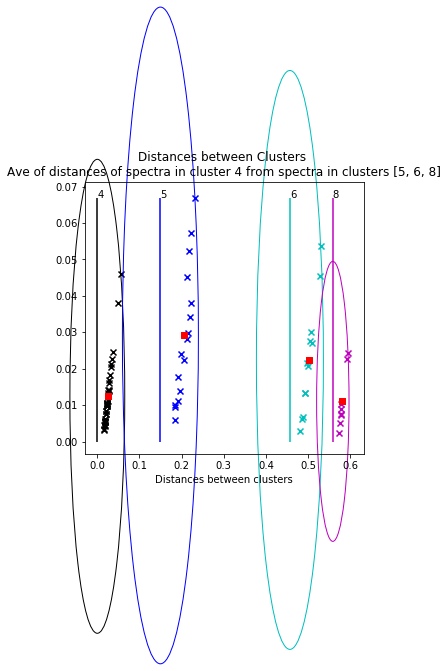

In [42]:
#Plot the similarity map for clusters 4 & 11 (ave)
max_sim = max([max(D[i]) for i in range(len(D))])

fig,ax = plt.subplots(figsize=(5,5))
pp=0
v=[4,5,6,8]
color = ['k','b','c','m','y','k','b','c','m','y','b']
color_idx=0
for i in range(len(v)):
    clust = v[i]-1
    
    for j in range(len(Big_D[clust])): 
        ax.scatter(pp+np.mean(Big_D[clust][j]),D[clust][j],marker='x',color=color[color_idx])
        #ax.scatter([pp]*len(D[v[i]]),D[v[i]],marker='x')
    plt.xlabel('Distances between clusters')
    plt.ylabel('')
    ax.set_title('Distances between Clusters \n' 'Ave of distances of spectra in cluster '+str(v[0])+ ' from spectra in clusters '+ str(v[1:]))
    #ax.set_title('Distances between Clusters')
    ax.scatter(pp+np.mean(Big_D[clust]),np.mean(D[clust]),color = 'r',marker ='s')
    plt.vlines(pp,0,max_sim,color=color[color_idx])
    #plt.vlines(pp,-0.1,0.1,color=color[color_idx])
    ax.annotate(clust+1,(pp,max_sim))
   
    
    #ax.set_xlim((-0.01,0.1))
    #ax.set_ylim((0,45000))
    
    circle_idx = np.argmax(np.mean(Big_D[clust],axis=1))
    x1=max(np.mean(Big_D[clust],axis=1))
    y1=D[clust][circle_idx]-np.mean(D[clust])
    rad = np.linalg.norm([x1,y1])
    circle1 = plt.Circle((pp,np.mean(D[clust])), rad, color=color[color_idx], fill=False,clip_on=False)
    #ax.gca()
    ax.add_artist(circle1)
    
    if i==len(v)-1:
        continue
    #pp = D_ave[v[0]-1][v[i+1]-1]
    pp = mean_Bigger_D[v[0]-1][v[i+1]-1]
    color_idx+=1
    #print(max(D[clust]))


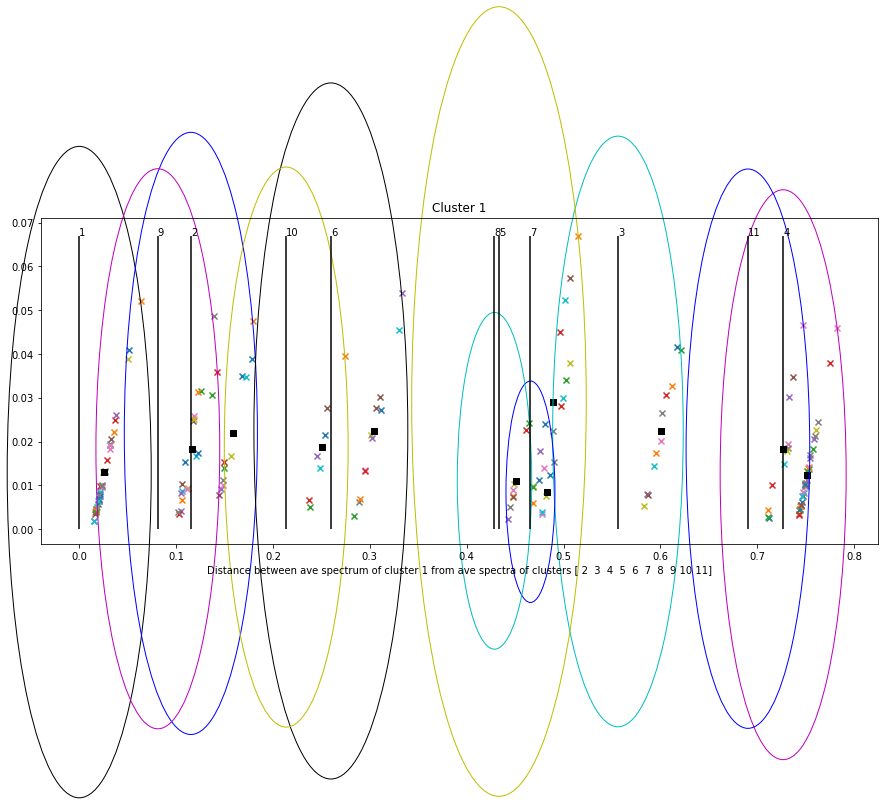

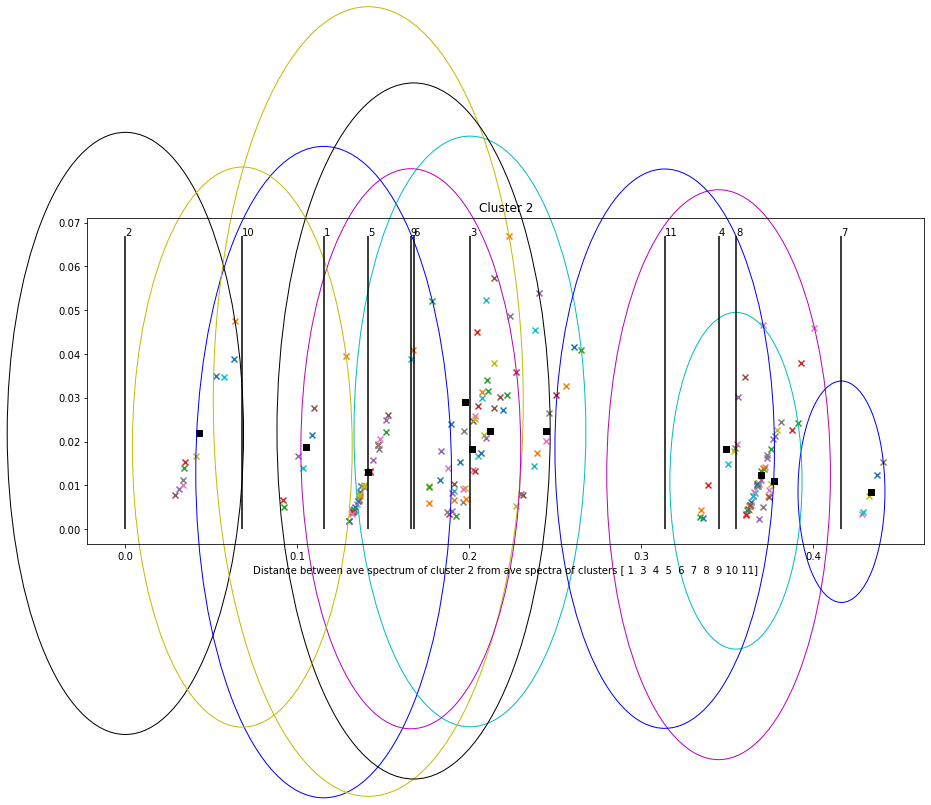

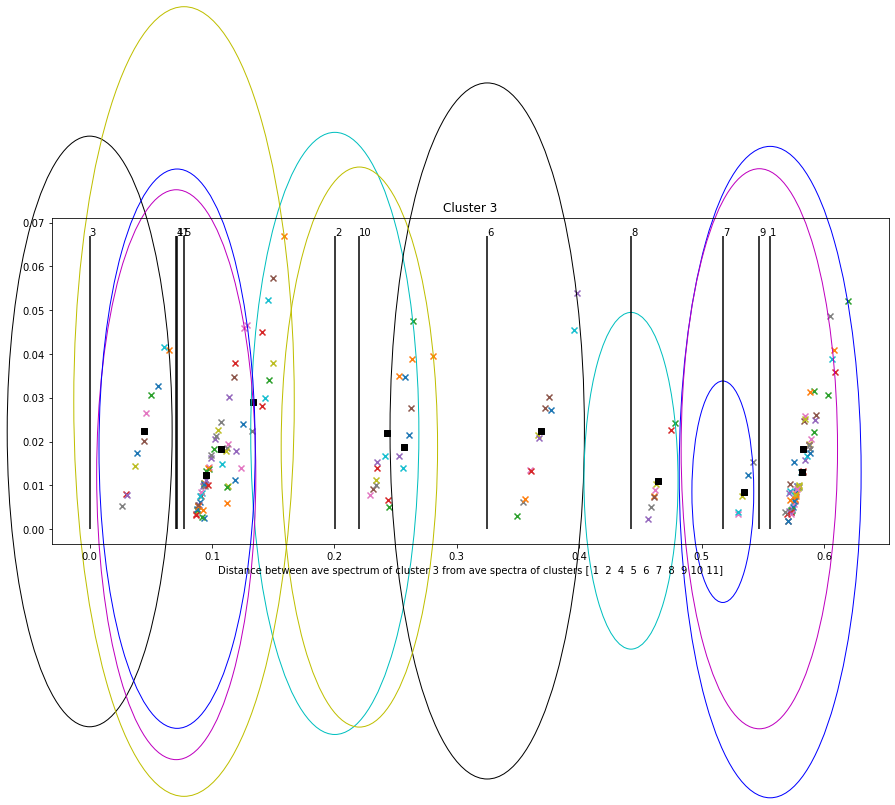

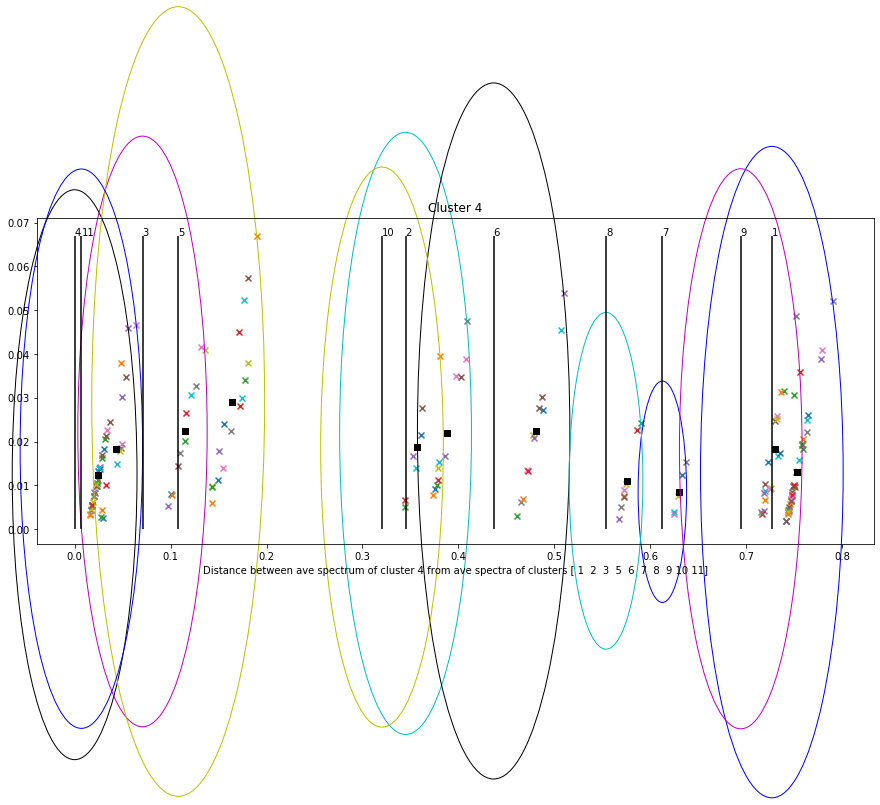

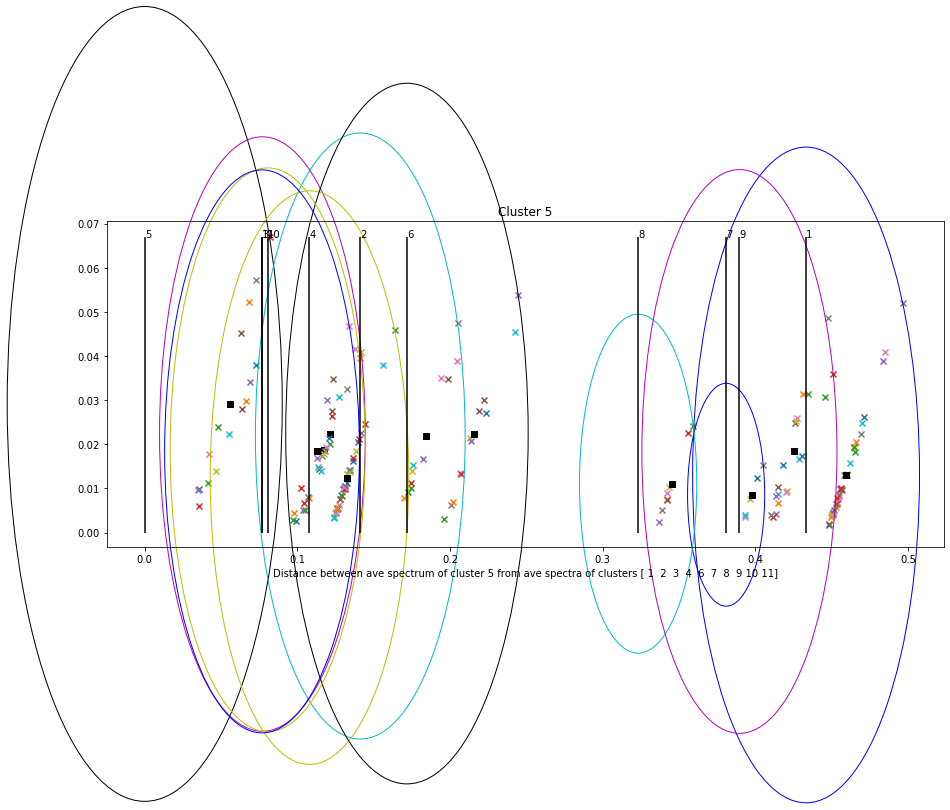

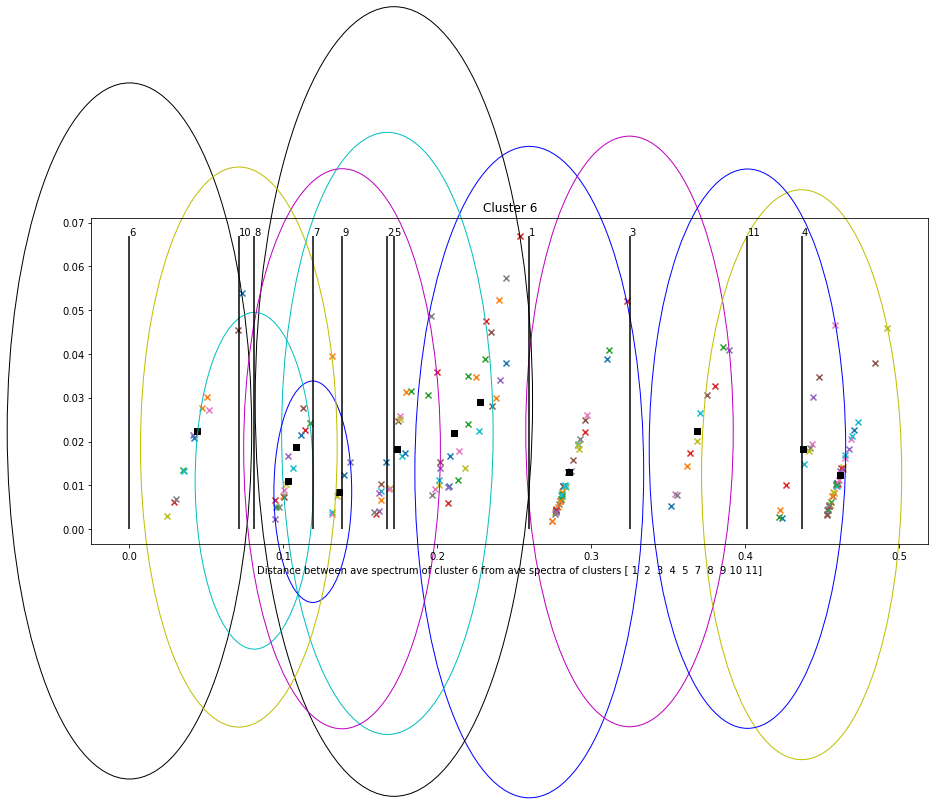

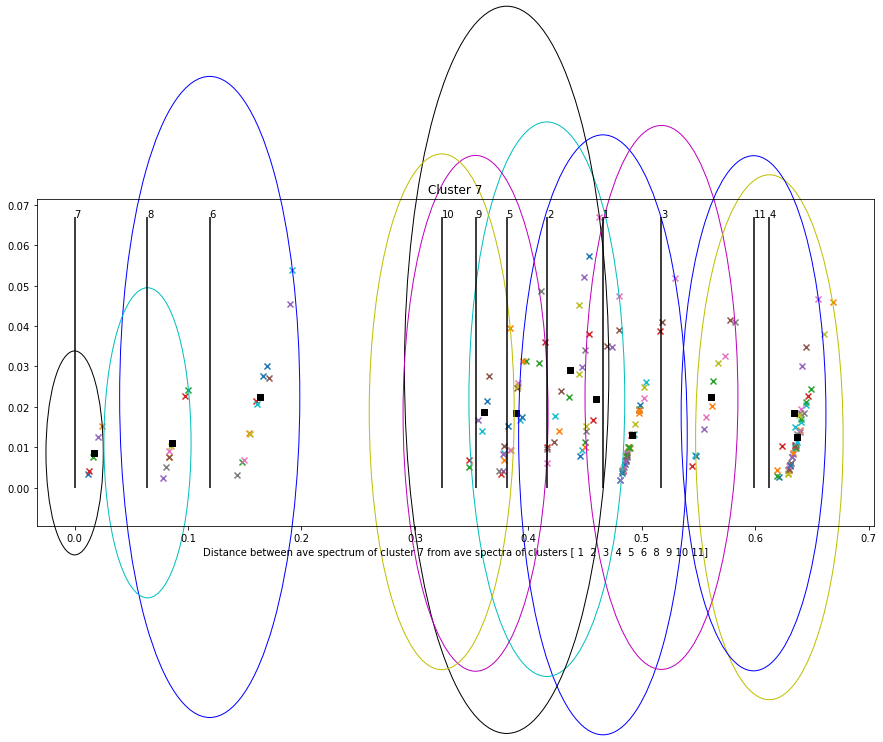

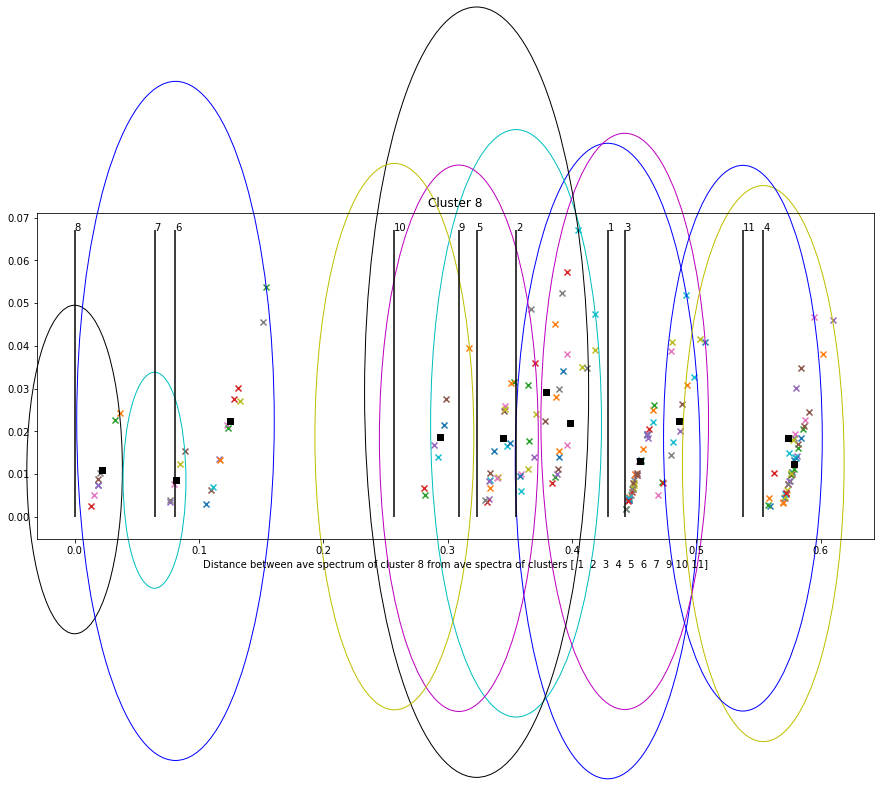

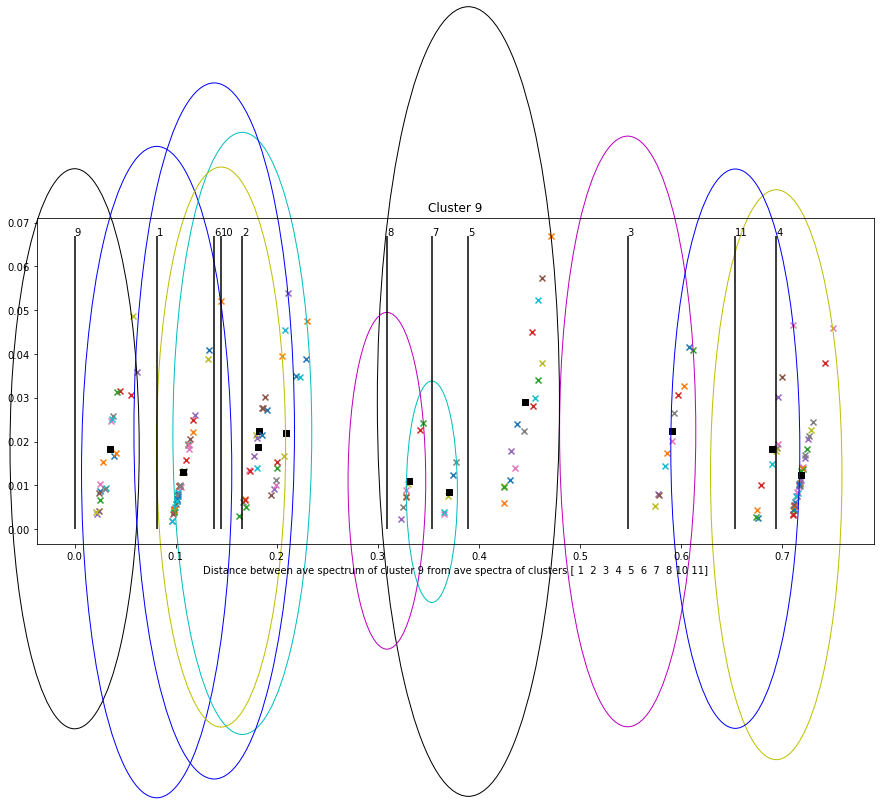

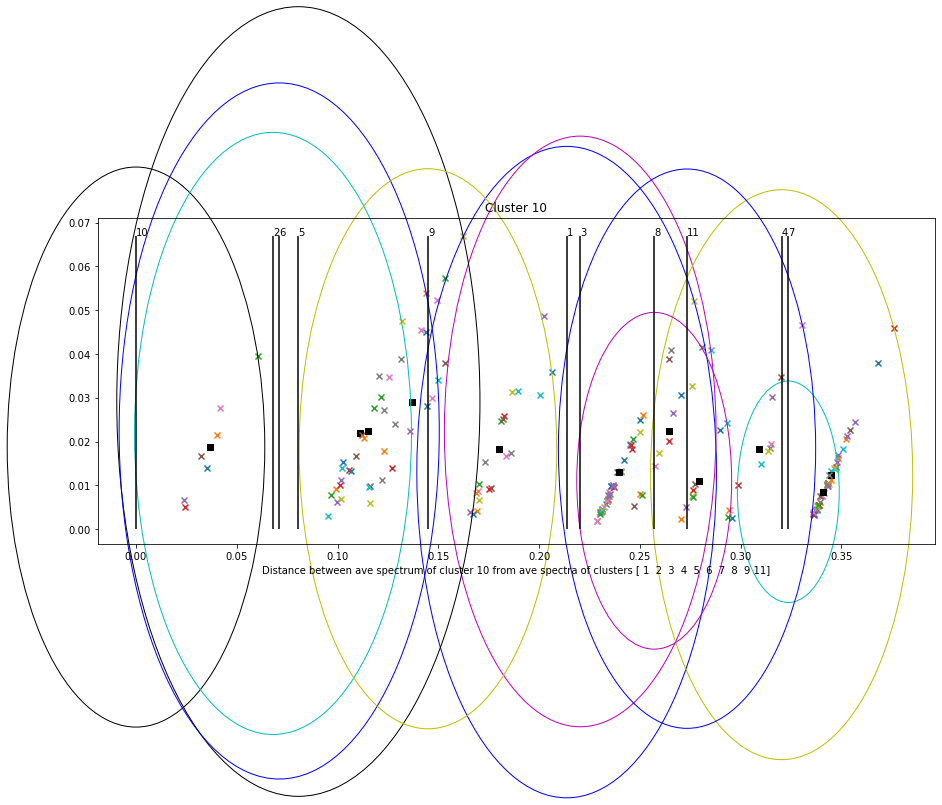

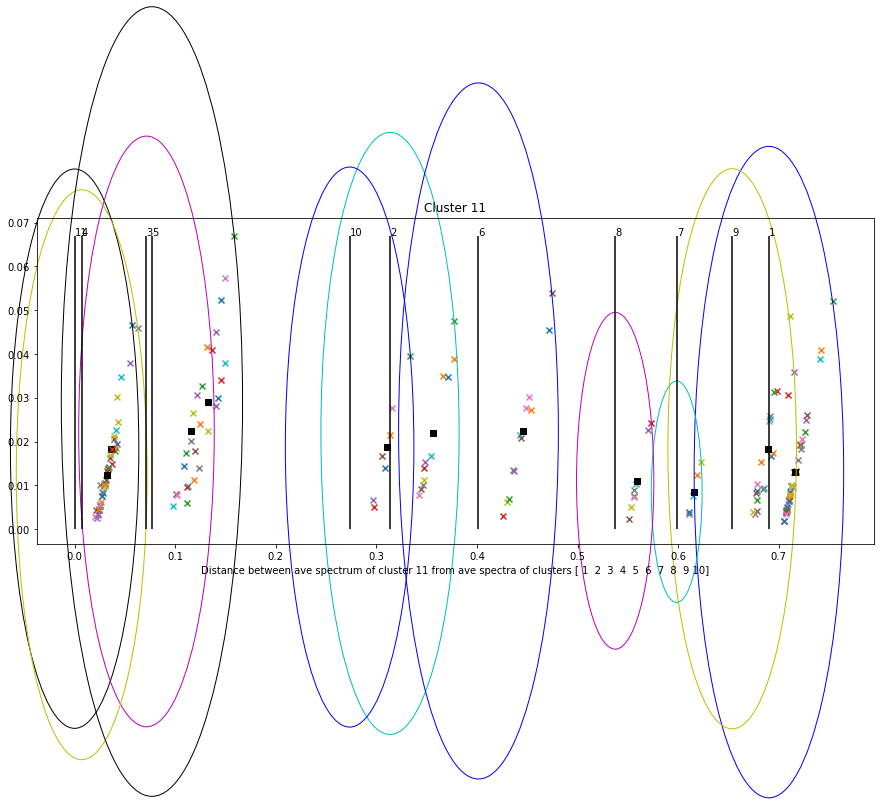

In [44]:
#Plot the similarity map for all clusters (ave)
max_sim = max([max(D[i]) for i in range(len(D))])



for m in range(len(D)):
    clcall = [m]+[i for i,v in enumerate(range(11)) if i!= m]
    #print(np.transpose(clcall))
    
    
    pp=0
    color = ['k','b','c','m','y','k','b','c','m','y','b']
    color_idx=0
    fig,ax = plt.subplots(figsize=(15,6))
    for aa in range(len(D)):
        clust = clcall[aa]
        
        for j in range(len(Big_D[clust])): 
            ax.scatter([pp+np.mean(Big_D[clust][j])],D[clust][j],marker='x')
        
        plt.xlabel('Ave of distances of spectra in cluster '+str(clcall[0]+1)+ ' from spectra in clusters '+ str(np.array(clcall[1:])+1))
        plt.ylabel('')
        ax.set_title('Distances between Clusters')

        ax.scatter([pp+np.mean(Big_D[clust])],np.mean(D[clust]),color='k',marker ='s')
        
        plt.vlines(pp,0,max_sim,color='k')
        ax.annotate(clust+1,(pp,max_sim))
        
        circle_idx = np.argmax(np.mean(Big_D[clust],axis=1))
        x1=max(np.mean(Big_D[clust],axis=1))
        y1=D[clust][circle_idx]-np.mean(D[clust])
        rad = np.linalg.norm([x1,y1])
        circle1 = plt.Circle((pp,np.mean(D[clust])), rad, color=color[color_idx], fill=False,clip_on=False)
        #ax.gca()
        ax.add_artist(circle1)

        #print(clust)
        if aa==len(D)-1:
            continue

        pp = D_ave[clcall[0],clcall[aa+1]]
        color_idx+=1
        #print(aa,clcall[0],clcall[aa+1],pp)
    #plt.xticks(np.arange(0, 1, 0.05))
    plt.xlabel('Distance between ave spectrum of cluster '+str(clcall[0]+1)+ ' from ave spectra of clusters '+ str(np.array(clcall[1:])+1))
    plt.ylabel('')
    ax.set_title('Cluster '+str(m+1))    
    

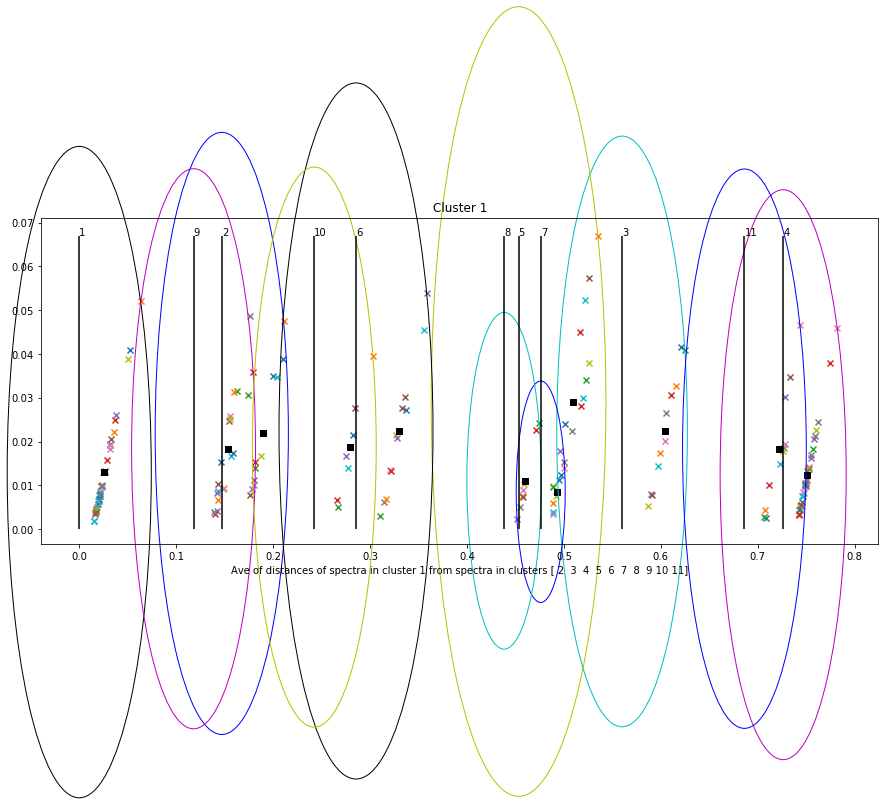

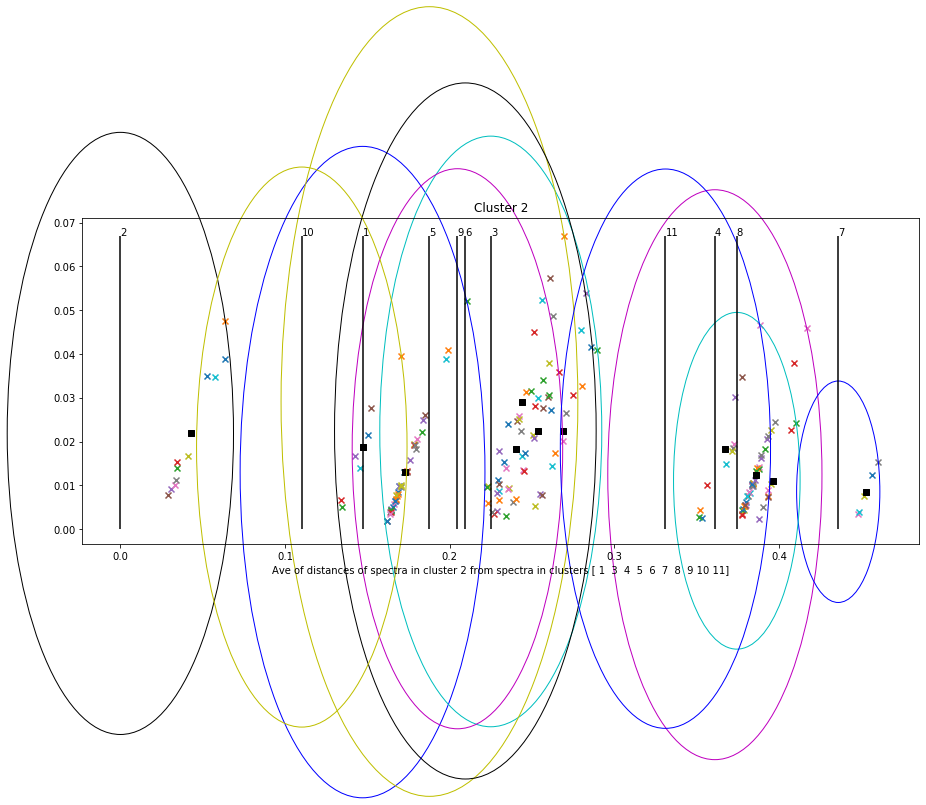

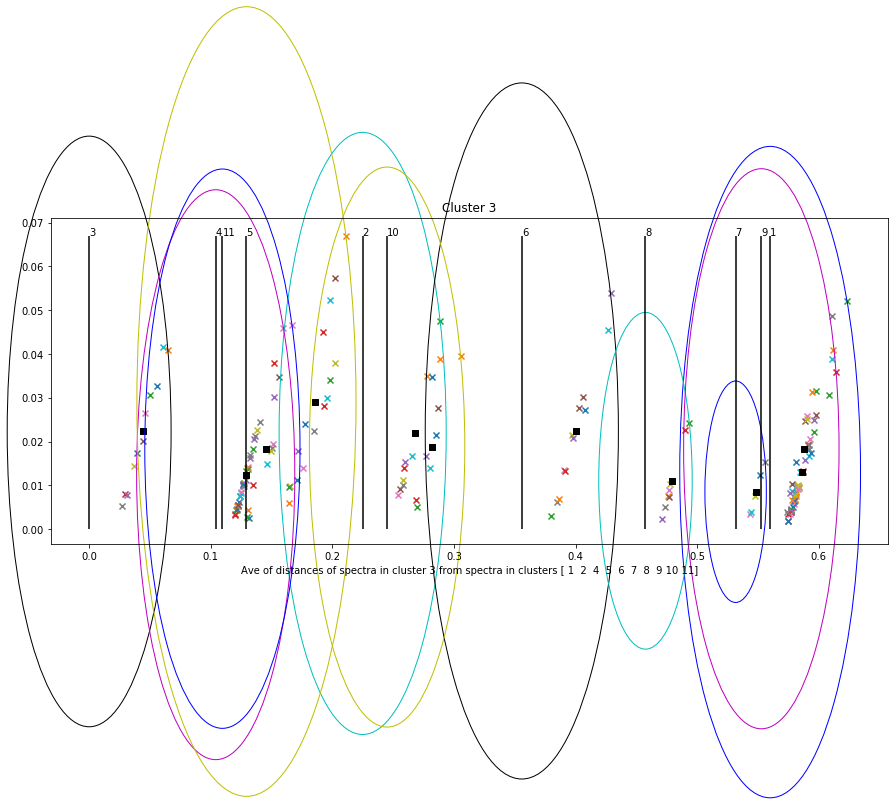

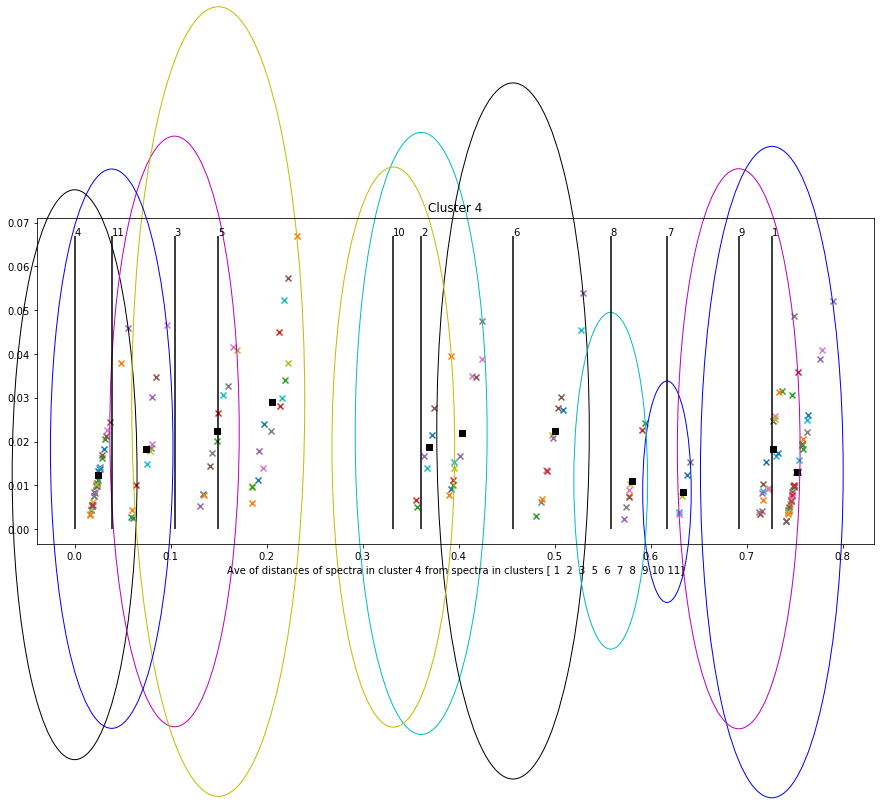

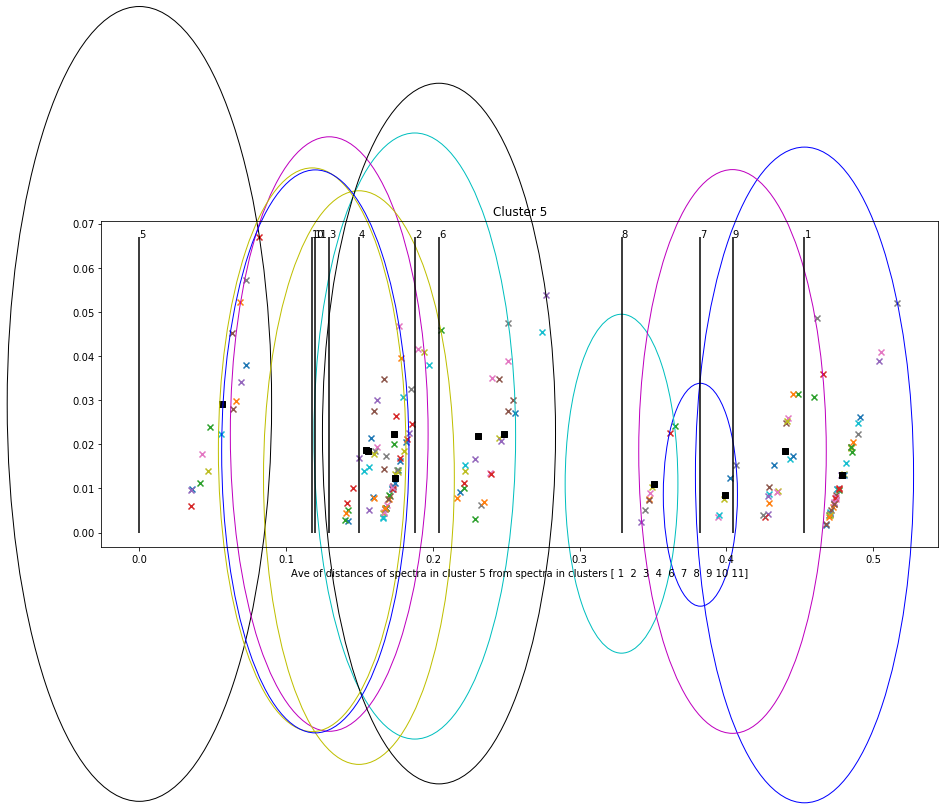

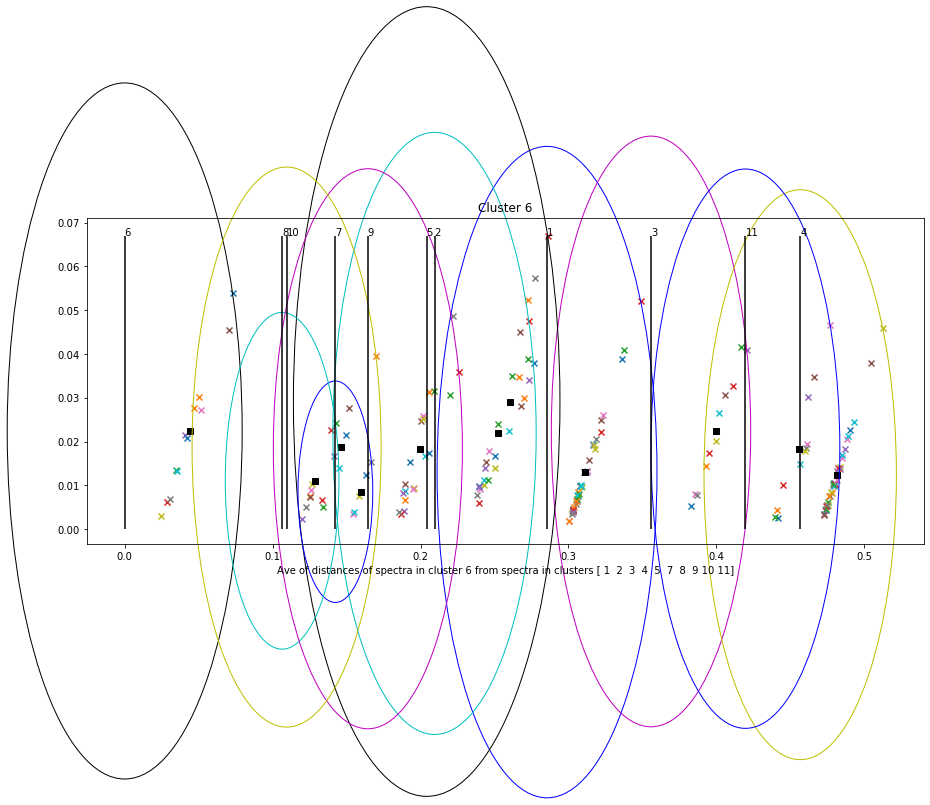

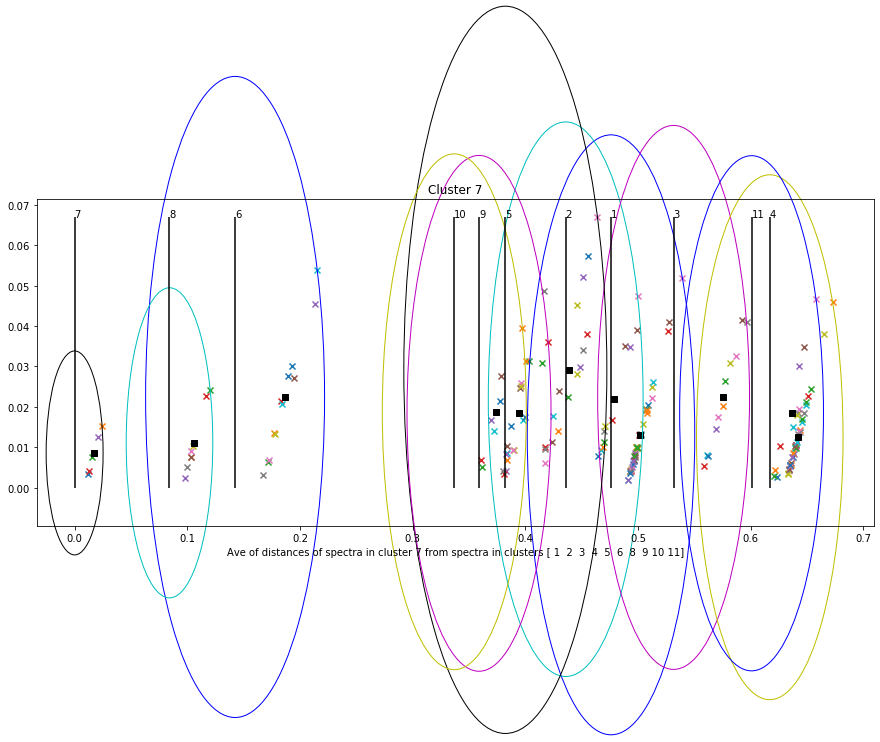

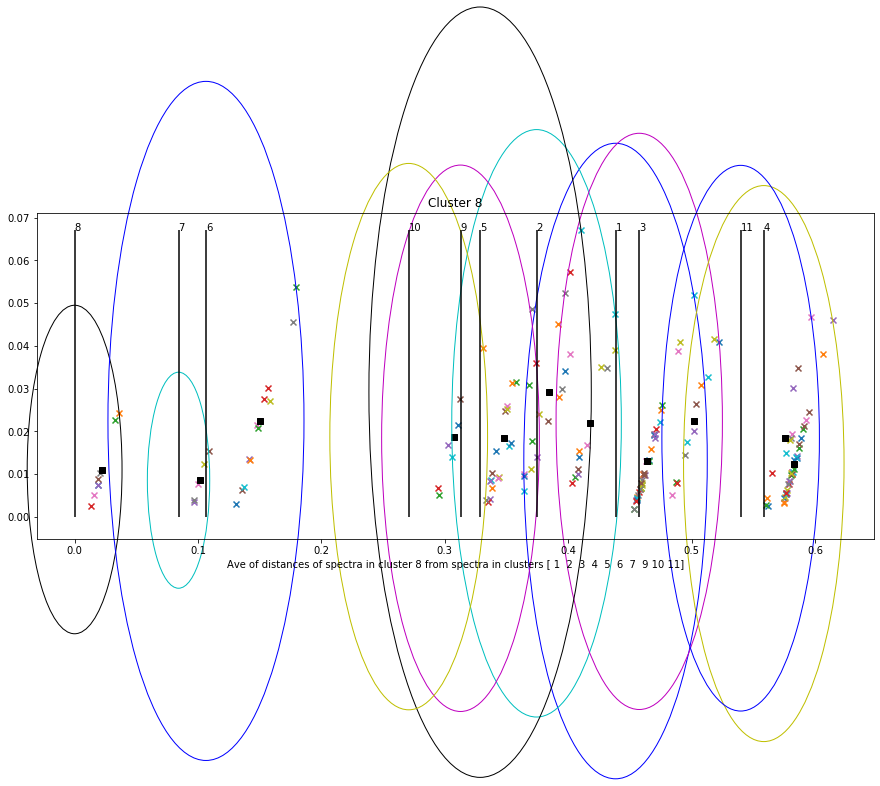

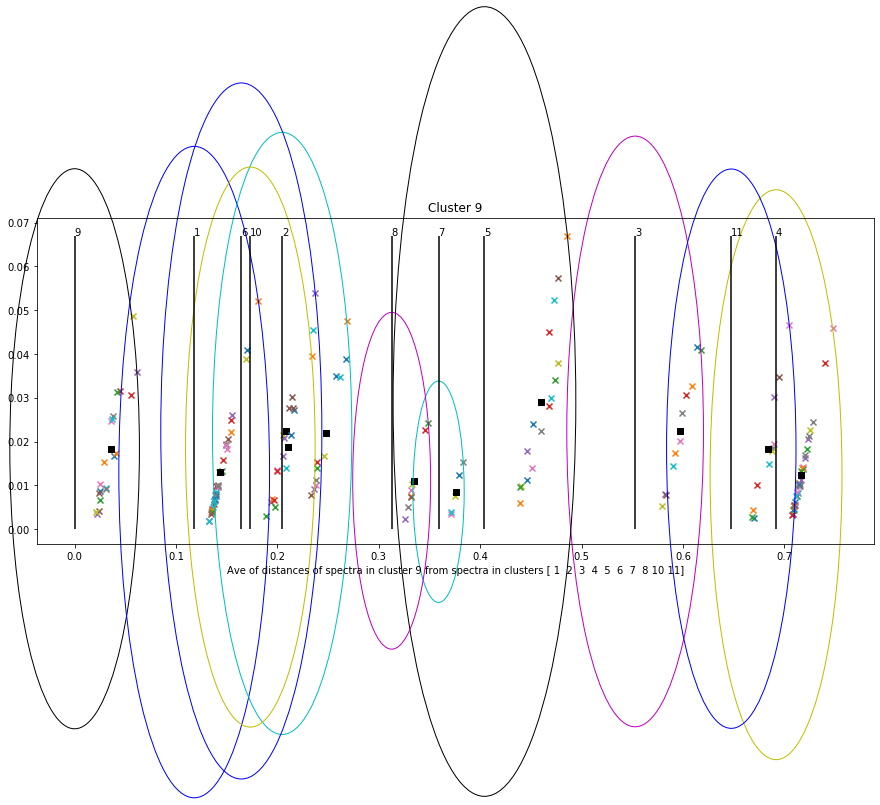

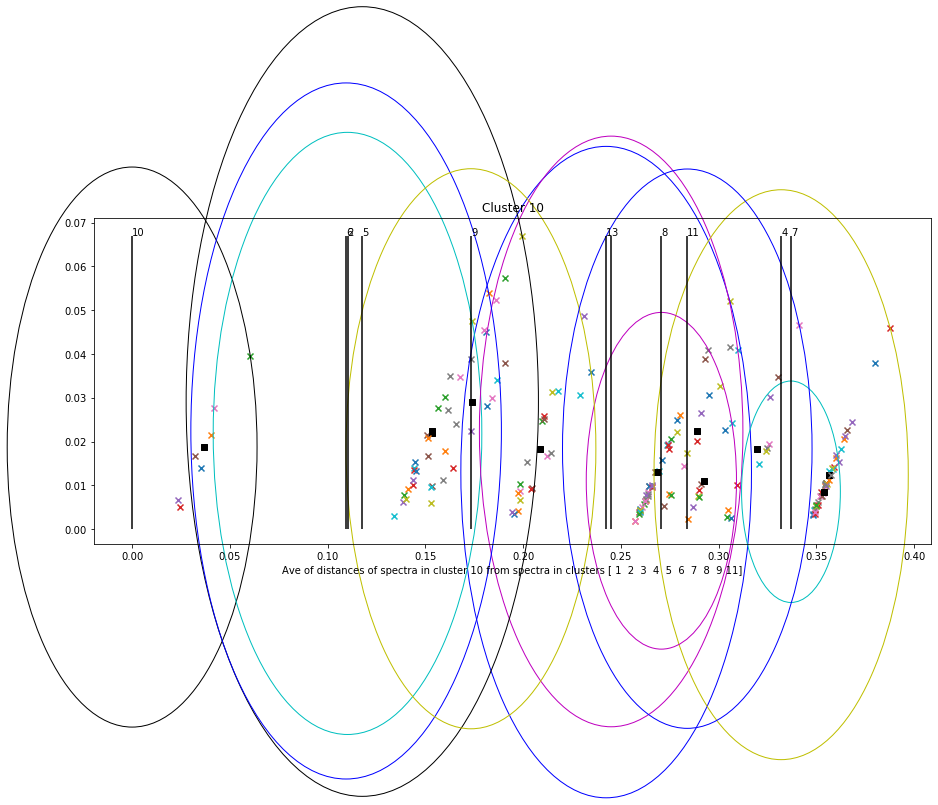

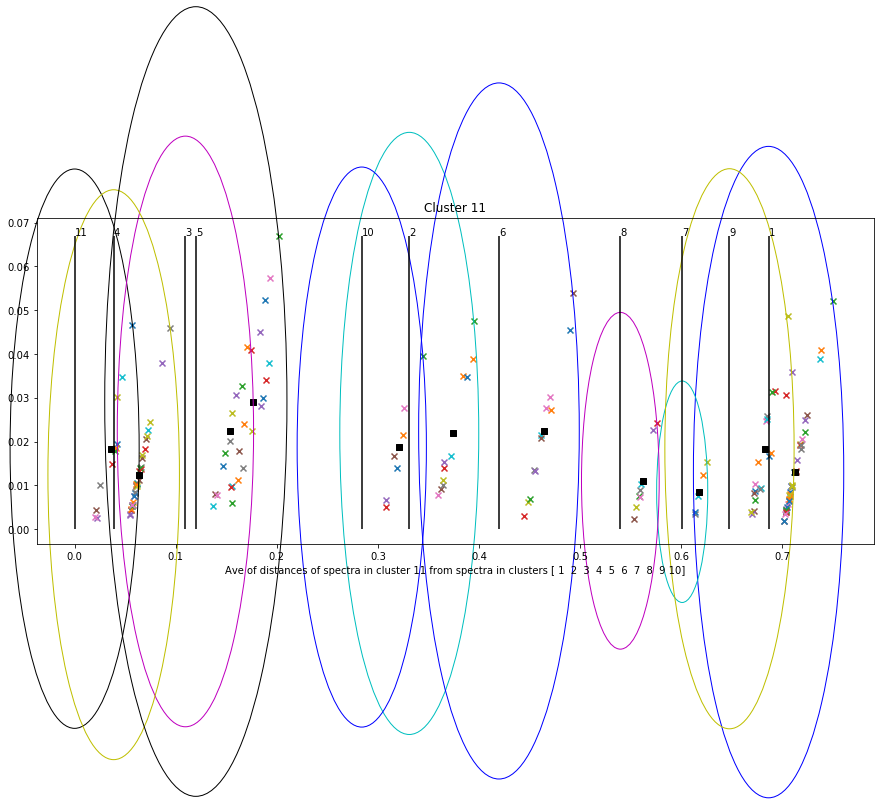

In [45]:
#Plot the similarity map for all clusters (b_d value)
max_sim = max([max(D[i]) for i in range(len(D))])



for m in range(len(D)):
    clcall = [m]+[i for i,v in enumerate(range(11)) if i!= m]
    #print(np.transpose(clcall))
    
    
    pp=0
    color = ['k','b','c','m','y','k','b','c','m','y','b']
    color_idx=0
    fig,ax = plt.subplots(figsize=(15,6))
    for aa in range(len(D)):
        clust = clcall[aa]
        
        for j in range(len(Big_D[clust])): 
            ax.scatter([pp+np.mean(Big_D[clust][j])],D[clust][j],marker='x')

        
        ax.scatter([pp+np.mean(Big_D[clust])],np.mean(D[clust]),color='k',marker ='s')
        
        
        plt.vlines(pp,0,max_sim,color='k')
        ax.annotate(clust+1,(pp,max_sim))
        
        circle_idx = np.argmax(np.mean(Big_D[clust],axis=1))
        x1=max(np.mean(Big_D[clust],axis=1))
        y1=D[clust][circle_idx]-np.mean(D[clust])
        rad = np.linalg.norm([x1,y1])
        circle1 = plt.Circle((pp,np.mean(D[clust])), rad, color=color[color_idx], fill=False,clip_on=False)
        #ax.gca()
        ax.add_artist(circle1)

        #print(clust)
        if aa==len(D)-1:
            continue

        pp = mean_Bigger_D[clcall[0]][clcall[aa+1]]
        color_idx+=1
        #print(aa,clcall[0],clcall[aa+1],pp)
    #plt.xticks(np.arange(0, 1, 0.05))
    plt.xlabel('Ave of distances of spectra in cluster '+str(clcall[0]+1)+ ' from spectra in clusters '+ str(np.array(clcall[1:])+1))
    plt.ylabel('')
    ax.set_title('Cluster '+str(m+1))  
    

In [ ]:
np.shape(mean_Bigger_D)

In [ ]:
D_ave[0]

In [ ]:
#Plot each cluster's spectra and its average
# fig, ax = plt.subplots(figsize=(10,8))
# pp = 0

# for j in range(1,12):
    
#     new_labels = [i+1 for i,v in enumerate(new_truth_labels) if v==j]
    
#     for ii in new_labels:
#         ax.plot(dataGrid.data[1][:,0],X[ii-1]+pp)
    
#     ax.plot(dataGrid.data[1][:,0],Big_clustave[j-1]+pp, 'k')
#     pp +=500

   


# ax.set_title('Cluster spectra and ave')

In [ ]:
np.transpose(new_truth_labels)